# HACKATHON PROJECT: Predicting client subscribing to bank's term deposit based on his marketing campaign
# Group 4: Clyde M, Krupa S,Sagar P,Sagar K,Rajesh B
# Date:  3/11/18 & 4/11/18

In [196]:
#Libraraies used
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [197]:
df = pd.read_csv('./data/bank-additional-full.csv', delimiter=';')
df1 = df.copy()

In [198]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# Check number of rows and columns

In [199]:
df.shape

(41188, 21)

# Check datatypes and missing values

In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

In [201]:
numeric_df = df._get_numeric_data()
numeric_df_is_zero = numeric_df.isin([0])

# Check for 0's in numerical columns

In [202]:
for column in numeric_df_is_zero.columns:
    print(column)
    print(numeric_df_is_zero[column].value_counts())
    print('________________________________')

age
False    41188
Name: age, dtype: int64
________________________________
duration
False    41184
True         4
Name: duration, dtype: int64
________________________________
campaign
False    41188
Name: campaign, dtype: int64
________________________________
pdays
False    41173
True        15
Name: pdays, dtype: int64
________________________________
previous
True     35563
False     5625
Name: previous, dtype: int64
________________________________
emp.var.rate
False    41188
Name: emp.var.rate, dtype: int64
________________________________
cons.price.idx
False    41188
Name: cons.price.idx, dtype: int64
________________________________
cons.conf.idx
False    41188
Name: cons.conf.idx, dtype: int64
________________________________
euribor3m
False    41188
Name: euribor3m, dtype: int64
________________________________
nr.employed
False    41188
Name: nr.employed, dtype: int64
________________________________


## Since zero values in data is justified, we will not consider it as missing values

In [203]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


## If the max value is too far from the 75th percentile it is likely to have outliers

# Check if mean is too far from the median

In [204]:
df.describe(percentiles=[.5])

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


# Check cateogrical columns

In [205]:
categorical_df = df[list(set(df.columns) - set(numeric_df.columns))]
categorical_df.head()

,contact,default,day_of_week,poutcome,education,marital,loan,y,month,job,housing
0,telephone,no,mon,nonexistent,basic.4y,married,no,no,may,housemaid,no
1,telephone,unknown,mon,nonexistent,high.school,married,no,no,may,services,no
2,telephone,no,mon,nonexistent,high.school,married,no,no,may,services,yes
3,telephone,no,mon,nonexistent,basic.6y,married,no,no,may,admin.,no
4,telephone,no,mon,nonexistent,high.school,married,yes,no,may,services,no


# Replace unknown with Mode of the respective columns

In [206]:
for column in categorical_df.columns:
    print('--------------------------------')
    print(column)
    print(categorical_df[column].value_counts())

--------------------------------
contact
cellular     26144
telephone    15044
Name: contact, dtype: int64
--------------------------------
default
no         32588
unknown     8597
yes            3
Name: default, dtype: int64
--------------------------------
day_of_week
thu    8623
mon    8514
wed    8134
tue    8090
fri    7827
Name: day_of_week, dtype: int64
--------------------------------
poutcome
nonexistent    35563
failure         4252
success         1373
Name: poutcome, dtype: int64
--------------------------------
education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64
--------------------------------
marital
married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64
--------------------------------
loan
no         33950
y

In [207]:
categorical_df = categorical_df.replace('unknown', np.nan)

In [208]:
columns_to_replace_with_mode = ['default', 'housing', 'job', 'education', 'loan', 'marital']
for column in columns_to_replace_with_mode:
    categorical_df[column] = categorical_df[column].fillna(df[column].mode()[0])

In [209]:
for column in columns_to_replace_with_mode:
    print('--------------------------------')
    print(column)
    print(categorical_df[column].value_counts())

--------------------------------
default
no     41185
yes        3
Name: default, dtype: int64
--------------------------------
housing
yes    22566
no     18622
Name: housing, dtype: int64
--------------------------------
job
admin.           10752
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
Name: job, dtype: int64
--------------------------------
education
university.degree      13899
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
illiterate                18
Name: education, dtype: int64
--------------------------------
loan
no     34940
yes     6248
Name: loan, dtype: int64
--------------------------------
marital
married     25008
single      11568
divorced     4612
Name: marital, dtype: int64


In [210]:
cleaned_df = pd.concat([numeric_df, categorical_df], axis=1)

In [211]:
cleaned_df.isnull().sum()

age               0
duration          0
campaign          0
pdays             0
previous          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
contact           0
default           0
day_of_week       0
poutcome          0
education         0
marital           0
loan              0
y                 0
month             0
job               0
housing           0
dtype: int64

In [212]:
cleaned_df.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,default,day_of_week,poutcome,education,marital,loan,y,month,job,housing
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,no,mon,nonexistent,basic.4y,married,no,no,may,housemaid,no
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,no,mon,nonexistent,high.school,married,no,no,may,services,no
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,no,mon,nonexistent,high.school,married,no,no,may,services,yes
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,no,mon,nonexistent,basic.6y,married,no,no,may,admin.,no
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,no,mon,nonexistent,high.school,married,yes,no,may,services,no


In [213]:
len(numeric_df.columns)

10

# Univariate analysis of categorical columns

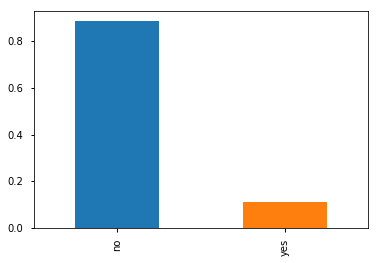

In [214]:
cleaned_df["y"].value_counts(normalize=True).plot.bar()

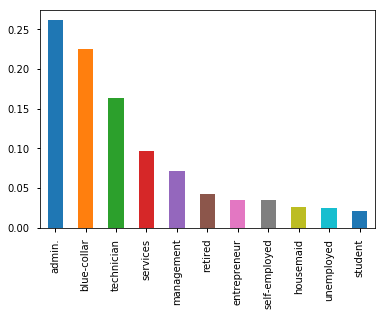

In [215]:
# students should inculcate fmore saving habits
cleaned_df["job"].value_counts(normalize=True).plot.bar()

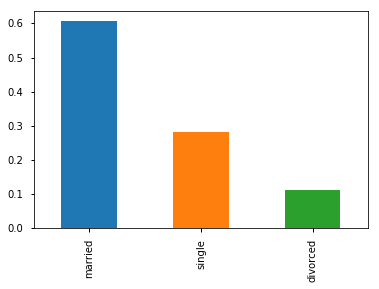

In [216]:

cleaned_df["marital"].value_counts(normalize=True).plot.bar()

# married people are being targeted more

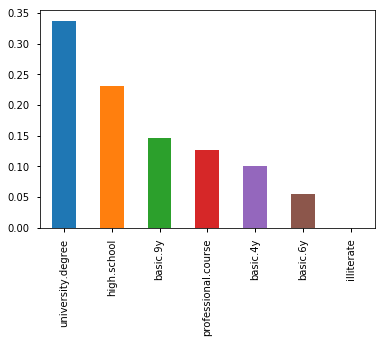

In [217]:

cleaned_df["education"].value_counts(normalize=True).plot.bar()


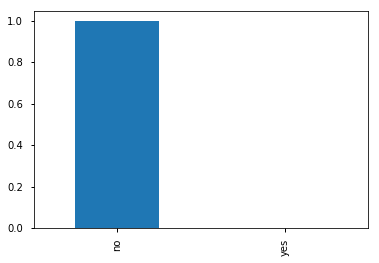

In [218]:

cleaned_df["default"].value_counts(normalize=True).plot.bar()


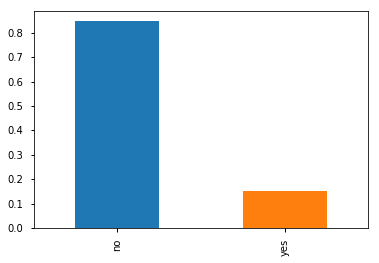

In [219]:

cleaned_df["loan"].value_counts(normalize=True).plot.bar()

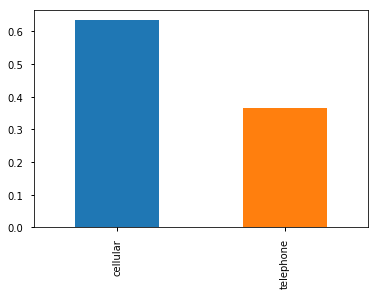

In [220]:

cleaned_df["contact"].value_counts(normalize=True).plot.bar()

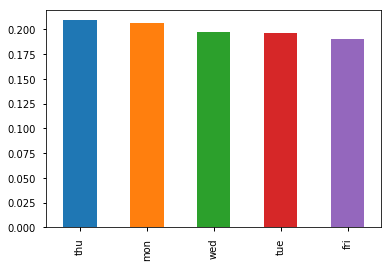

In [221]:

cleaned_df["day_of_week"].value_counts(normalize=True).plot.bar()


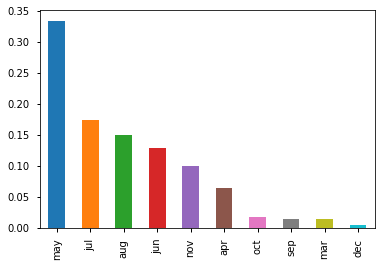

In [222]:
cleaned_df["month"].value_counts(normalize=True).plot.bar()

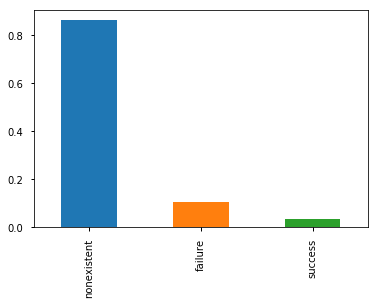

In [223]:
cleaned_df["poutcome"].value_counts(normalize=True).plot.bar()

# Univariate analysis of numerical columns

/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


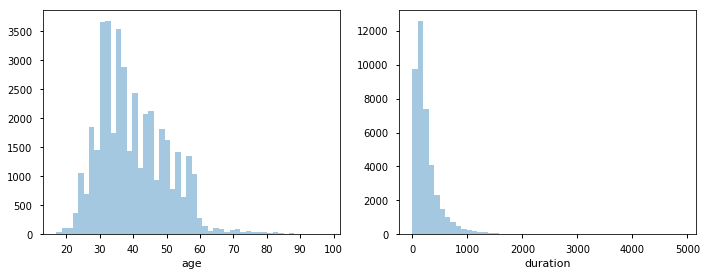

/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


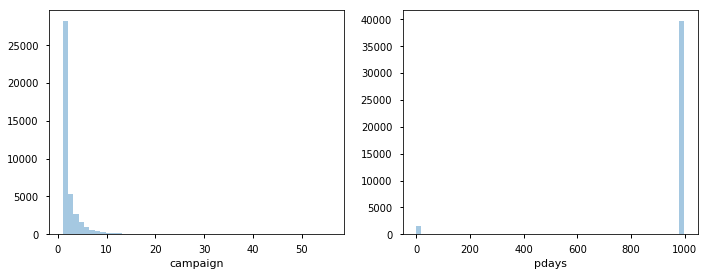

/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


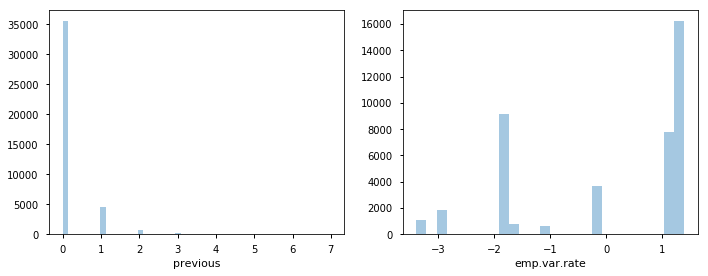

/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


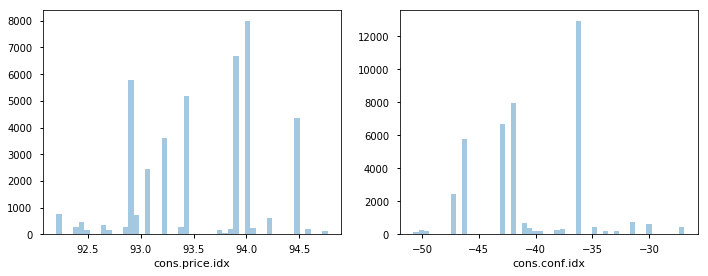

/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


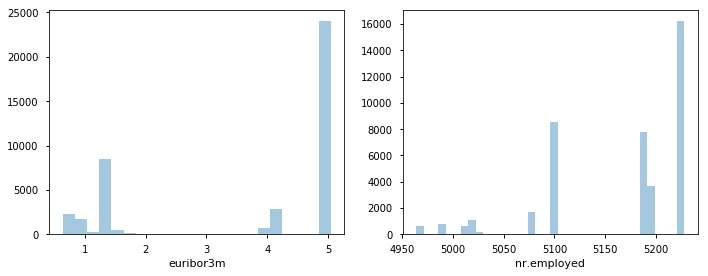

In [224]:
num_cols = numeric_df.columns;
for i in range(0,len(num_cols),2):
    if len(num_cols) > i+1:
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        sns.distplot(cleaned_df[num_cols[i]], kde=False)
        plt.subplot(122)            
        sns.distplot(cleaned_df[num_cols[i+1]], kde=False)
        plt.tight_layout()
        plt.show()

    else:
        sns.distplot(dataframe[num_cols[i]], kde=False)

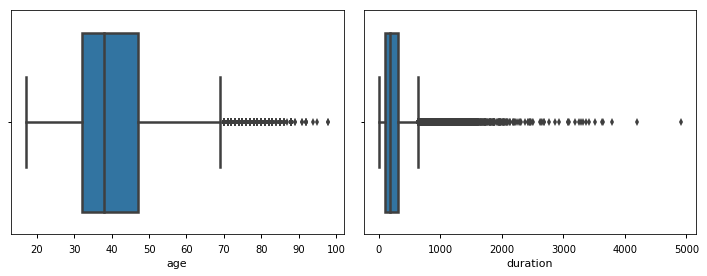

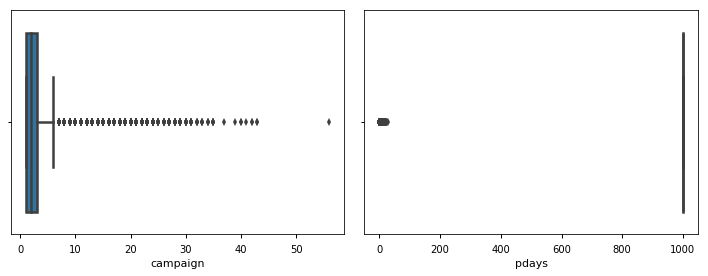

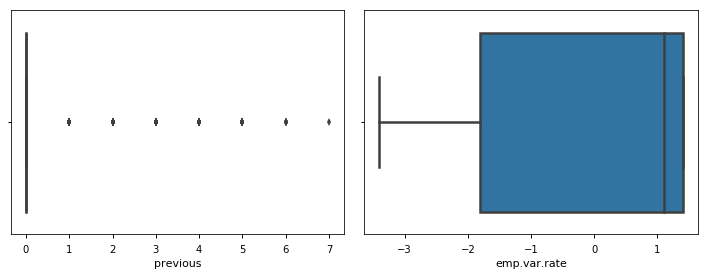

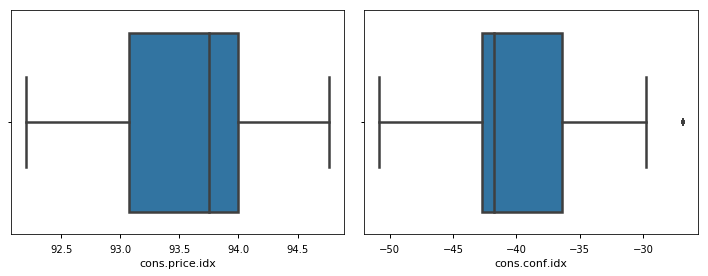

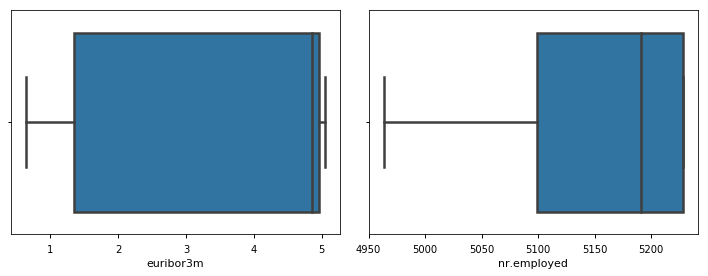

In [225]:
num_cols = numeric_df.columns;
for i in range(0,len(num_cols),2):
    if len(num_cols) > i+1:
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        sns.boxplot(cleaned_df[num_cols[i]])
        plt.subplot(122)            
        sns.boxplot(cleaned_df[num_cols[i+1]])
        plt.tight_layout()
        plt.show()

    else:
        sns.distplot(dataframe[num_cols[i]], kde=False)

# Detect outliers in numerical columns

In [226]:
for column in numeric_df.columns:
    q1 = numeric_df[column].quantile(0.25)
    q3 = numeric_df[column].quantile(0.75)
    iqr = q3 - q1
    fence_low = q1 - (1.5*iqr)
    fence_high = q3 + (1.5*iqr)
    
    print(column + ' ---------', numeric_df.loc[(numeric_df[column] < fence_low) | (numeric_df[column] > fence_high)].shape[0])
    

age --------- 469
duration --------- 2963
campaign --------- 2406
pdays --------- 1515
previous --------- 5625
emp.var.rate --------- 0
cons.price.idx --------- 0
cons.conf.idx --------- 447
euribor3m --------- 0
nr.employed --------- 0


# Performing log transformation to remove outliers

In [227]:
log_transformed_numeric_df = numeric_df.copy()
for column in log_transformed_numeric_df.columns:
    log_transformed_numeric_df[column] = np.log(log_transformed_numeric_df[column])

/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [228]:
for column in log_transformed_numeric_df.columns:
    q1 = log_transformed_numeric_df[column].quantile(0.25)
    q3 = log_transformed_numeric_df[column].quantile(0.75)
    iqr = q3 - q1
    fence_low = q1 - (1.5*iqr)
    fence_high = q3 + (1.5*iqr)
    
    print(column + ' ---------', log_transformed_numeric_df.loc[(log_transformed_numeric_df[column] < fence_low) | (log_transformed_numeric_df[column] > fence_high)].shape[0])
    

age --------- 70
duration --------- 1068
campaign --------- 355
pdays --------- 1515
previous --------- 0
emp.var.rate --------- 0
cons.price.idx --------- 0
cons.conf.idx --------- 0
euribor3m --------- 0
nr.employed --------- 0


In [229]:
cleaned_df_copy = cleaned_df.copy()

In [230]:
encoder = LabelEncoder()
cleaned_df_copy['y'] = encoder.fit_transform(cleaned_df_copy['y'])

In [231]:
categorical_df.columns

Index(['contact', 'default', 'day_of_week', 'poutcome', 'education', 'marital',
       'loan', 'y', 'month', 'job', 'housing'],
      dtype='object')

# Bivariate Analysis

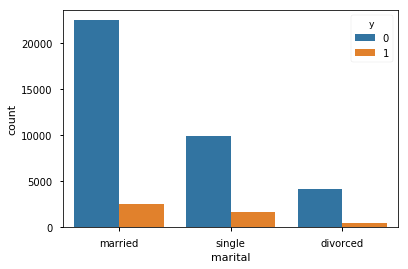

In [232]:
sns.countplot(x='marital', hue='y', data=cleaned_df_copy)

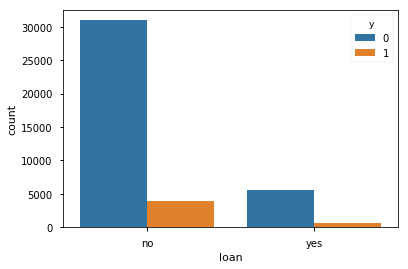

In [233]:
sns.countplot(x='loan', hue='y', data=cleaned_df_copy)

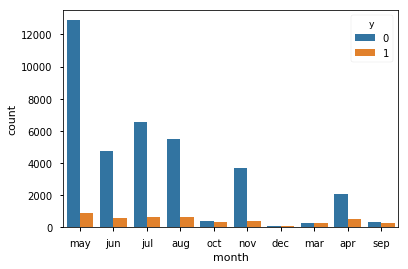

In [234]:
sns.countplot(x='month', hue='y', data=cleaned_df_copy)

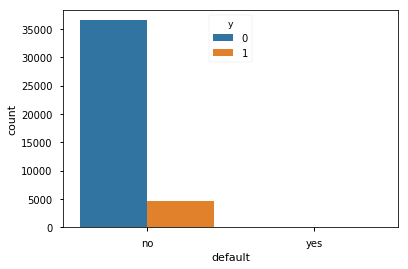

In [235]:
sns.countplot(x='default', hue='y', data=cleaned_df_copy)

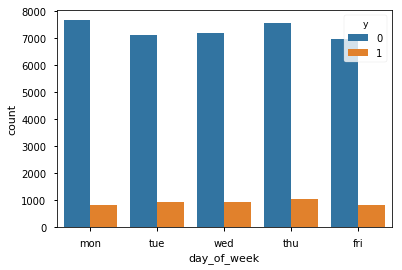

In [236]:
sns.countplot(x='day_of_week', hue='y', data=cleaned_df_copy)

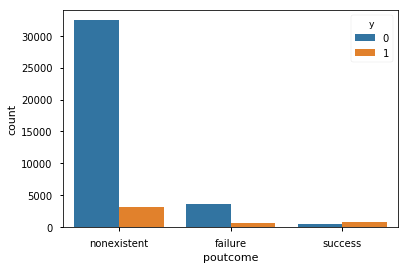

In [237]:
sns.countplot(x='poutcome', hue='y', data=cleaned_df_copy)

# Testing data for models

In [238]:
def logistic_regression(df):
    X = df.drop(['y'], axis=1)
    y = df['y']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    print(log_reg.score(X_test, y_test))
    print(classification_report(y_test, y_pred))

# Label encoding the categorical variables

In [239]:
categorical_df_encoded = categorical_df.apply(encoder.fit_transform)
encoded_df = pd.concat([numeric_df, categorical_df_encoded], axis=1)

In [240]:
logistic_regression(encoded_df)

/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9104960750991341
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     10965
           1       0.68      0.40      0.50      1392

   micro avg       0.91      0.91      0.91     12357
   macro avg       0.80      0.69      0.72     12357
weighted avg       0.90      0.91      0.90     12357



In [241]:
def svc(df, kernel='rbf'):
    X = df.drop(['y'], axis=1)
    y = df['y']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    svc = SVC(kernel=kernel)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    print(svc.score(X_test, y_test))
    print(classification_report(y_test, y_pred))

In [242]:
# svc(encoded_df)

In [243]:
def random_forrest(df):
    X = df.drop(['y'], axis=1)
    y = df['y']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    rfc = RandomForestClassifier()
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    print(rfc.score(X_test, y_test))
    print(classification_report(y_test, y_pred))
    return rfc

In [244]:
rfc = random_forrest(encoded_df)

/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9117908877559278
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     10965
           1       0.65      0.47      0.55      1392

   micro avg       0.91      0.91      0.91     12357
   macro avg       0.79      0.72      0.75     12357
weighted avg       0.90      0.91      0.91     12357



# Feature Selection

In [245]:
pd.Series(rfc.feature_importances_, index=encoded_df.columns[:-1]).sort_values().tail(10)

cons.conf.idx    0.032981
pdays            0.039665
education        0.041569
day_of_week      0.042250
campaign         0.043764
month            0.046847
nr.employed      0.080325
age              0.093531
euribor3m        0.105283
duration         0.329294
dtype: float64

In [246]:
corr = df.corr()            ## coorelation
corr

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
emp.var.rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
cons.price.idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
cons.conf.idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
nr.employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


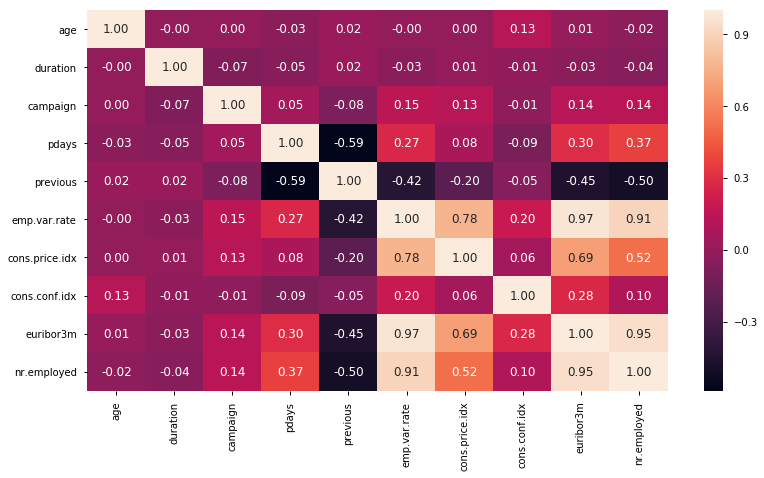

In [247]:
sns.set_context("notebook",font_scale = 1.0, rc = {"lines.linewidth":2.5})
plt.figure(figsize = (13,7))
a = sns.heatmap(corr, annot = True, fmt = ".2f")

In [248]:
def logistic_regression_rfe(df):
    X = df.drop(['y'], axis=1)
    y = df['y']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    log_reg = LogisticRegression()
    rfe = RFE(log_reg, 8)
    rfe = rfe.fit(X, y)
    print(rfe.ranking_)
    
    return pd.Series(rfe.ranking_, index=X.columns)

/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

[ 8  7  1 11  1  1  4  3 10  5  1 12  1  1  2  1  9  1  6 13]


/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


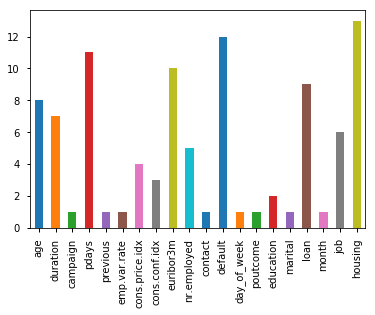

In [249]:
rfe = logistic_regression_rfe(encoded_df)
rfe.plot(kind='bar')

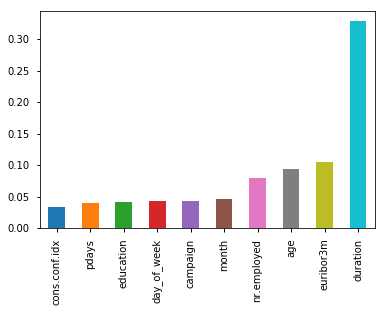

In [250]:
rfc_importances = pd.Series(rfc.feature_importances_, index=encoded_df.columns[:-1]).sort_values().tail(10)
rfc_importances.plot(kind='bar')

In [251]:
columns_selected = list(set(rfc_importances.index).union(set(rfe.index)))

In [252]:
def random_forrest_2(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    rfc = RandomForestClassifier()
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    print(rfc.score(X_test, y_test))
    print(classification_report(y_test, y_pred))
    return rfc

In [253]:
random_forrest_2(encoded_df[columns_selected], encoded_df['y'])

/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9087157076960427
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10965
           1       0.65      0.42      0.51      1392

   micro avg       0.91      0.91      0.91     12357
   macro avg       0.79      0.70      0.73     12357
weighted avg       0.90      0.91      0.90     12357



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [254]:
columns_selected = list(set(rfc_importances.index).intersection(set(rfe.index)))

In [255]:
columns_selected

['nr.employed',
 'age',
 'day_of_week',
 'education',
 'cons.conf.idx',
 'duration',
 'campaign',
 'month',
 'euribor3m',
 'pdays']

In [256]:
random_forrest_2(encoded_df[columns_selected], encoded_df['y'])

/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9105770008901837
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     10965
           1       0.64      0.48      0.55      1392

   micro avg       0.91      0.91      0.91     12357
   macro avg       0.79      0.72      0.75     12357
weighted avg       0.90      0.91      0.91     12357



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [257]:
rows_with_no = encoded_df[encoded_df['y'] == 0]
rows_with_yes = encoded_df[encoded_df['y'] == 1]

In [258]:
rows_with_no_for_data = rows_with_no.sample(rows_with_yes.shape[0])

In [259]:
balanced_encoded_df = rows_with_yes.append(rows_with_no_for_data)

In [260]:
logistic_regression(balanced_encoded_df)

0.8627873563218391
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      1392
           1       0.86      0.87      0.86      1392

   micro avg       0.86      0.86      0.86      2784
   macro avg       0.86      0.86      0.86      2784
weighted avg       0.86      0.86      0.86      2784



/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [261]:
svc(balanced_encoded_df)

/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.7780172413793104
              precision    recall  f1-score   support

           0       0.92      0.61      0.73      1392
           1       0.71      0.95      0.81      1392

   micro avg       0.78      0.78      0.78      2784
   macro avg       0.81      0.78      0.77      2784
weighted avg       0.81      0.78      0.77      2784



In [262]:
random_forrest(balanced_encoded_df)

0.8800287356321839
              precision    recall  f1-score   support

           0       0.90      0.85      0.88      1392
           1       0.86      0.91      0.88      1392

   micro avg       0.88      0.88      0.88      2784
   macro avg       0.88      0.88      0.88      2784
weighted avg       0.88      0.88      0.88      2784



/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Testing for Samples

In [263]:
rows_with_no_for_data = rows_with_no.sample(rows_with_yes.shape[0] + 6000)

In [264]:
imbalanced_encoded_df_10k = rows_with_yes.append(rows_with_no_for_data)

In [265]:
logistic_regression(imbalanced_encoded_df_10k)

0.862565445026178
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      3192
           1       0.81      0.72      0.76      1392

   micro avg       0.86      0.86      0.86      4584
   macro avg       0.85      0.82      0.83      4584
weighted avg       0.86      0.86      0.86      4584



/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [266]:
random_forrest(imbalanced_encoded_df_10k)

/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8717277486910995
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      3192
           1       0.81      0.76      0.78      1392

   micro avg       0.87      0.87      0.87      4584
   macro avg       0.85      0.84      0.85      4584
weighted avg       0.87      0.87      0.87      4584



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [267]:
rows_with_no_for_data = rows_with_no.sample(rows_with_yes.shape[0] + 7000)

In [268]:
imbalanced_encoded_df_15k = rows_with_yes.append(rows_with_no_for_data)

In [269]:
random_forrest(imbalanced_encoded_df_15k)

0.8603603603603603
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      3492
           1       0.76      0.74      0.75      1392

   micro avg       0.86      0.86      0.86      4884
   macro avg       0.83      0.83      0.83      4884
weighted avg       0.86      0.86      0.86      4884



/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Dealing with class imbalance

In [270]:
def xgboost(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    model = XGBClassifier(n_estimators=50, max_depth=4)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(model.score(X_test, y_test))
    print(classification_report(y_test, y_pred))
    return rfc

In [271]:
xgboost(encoded_df.drop(columns=['y']), encoded_df['y'])

0.917941247875698
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     10965
           1       0.68      0.51      0.58      1392

   micro avg       0.92      0.92      0.92     12357
   macro avg       0.81      0.74      0.77     12357
weighted avg       0.91      0.92      0.91     12357



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [272]:
def smote(X, y):
    smote = SMOTE(kind='regular')
    X_sm, y_sm =  smote.fit_sample(X, y.ravel())
    print(X_sm.shape, y_sm.shape)
    X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42, stratify=y_sm)

    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(model.score(X_test, y_test))
    print(accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    return rfc

In [273]:
smote(encoded_df.drop(columns=['y']), encoded_df['y'])

(73096, 20) (73096,)


/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9503397327739523
0.9503397327739523
[[10443   522]
 [  567 10397]]


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## We performed a log transformation before. However as log(0) is undefined and log of negative numbers does not exist, we cannot continue with this way. Square root will also be a problem with negative numbers.

In [274]:
numeric_df.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0


In [275]:
log_transformed_numeric_df.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,4.025352,5.564520,0.0,6.906755,-inf,0.09531,4.543231,NaN,1.580421,8.554682
1,4.043051,5.003946,0.0,6.906755,-inf,0.09531,4.543231,NaN,1.580421,8.554682
2,3.610918,5.420535,0.0,6.906755,-inf,0.09531,4.543231,NaN,1.580421,8.554682
3,3.688879,5.017280,0.0,6.906755,-inf,0.09531,4.543231,NaN,1.580421,8.554682
4,4.025352,5.726848,0.0,6.906755,-inf,0.09531,4.543231,NaN,1.580421,8.554682


# So we will try to replace the outliers using Winsorization

## Winsorization by replacing with second lowest value

In [276]:
winsorized_numeric_df = numeric_df.copy()
for column in winsorized_numeric_df.columns:
    winsorized_numeric_df[column] = winsorize(winsorized_numeric_df[column], limits=[0.05, 0.1],inclusive=(True, True))

In [277]:
for column in numeric_df.columns:
    q1 = numeric_df[column].quantile(0.25)
    q3 = numeric_df[column].quantile(0.75)
    iqr = q3 - q1
    fence_low = q1 - (1.5*iqr)
    fence_high = q3 + (1.5*iqr)
    
    print(column + ' ---------', numeric_df.loc[(numeric_df[column] < fence_low) | (numeric_df[column] > fence_high)].shape[0])
    

age --------- 469
duration --------- 2963
campaign --------- 2406
pdays --------- 1515
previous --------- 5625
emp.var.rate --------- 0
cons.price.idx --------- 0
cons.conf.idx --------- 447
euribor3m --------- 0
nr.employed --------- 0


In [278]:
for column in winsorized_numeric_df.columns:
    q1 = winsorized_numeric_df[column].quantile(0.25)
    q3 = winsorized_numeric_df[column].quantile(0.75)
    iqr = q3 - q1
    fence_low = q1 - (1.5*iqr)
    fence_high = q3 + (1.5*iqr)
    
    print(column + ' ---------', winsorized_numeric_df.loc[(winsorized_numeric_df[column] < fence_low) | (winsorized_numeric_df[column] > fence_high)].shape[0])
    

age --------- 0
duration --------- 0
campaign --------- 0
pdays --------- 0
previous --------- 5625
emp.var.rate --------- 0
cons.price.idx --------- 0
cons.conf.idx --------- 0
euribor3m --------- 0
nr.employed --------- 0


In [279]:
winsorized_df = pd.concat([categorical_df_encoded, winsorized_numeric_df], axis=1)

## Another stategy is to normalize the data

In [280]:
minmaxScaler = MinMaxScaler()
normalzied_numeric_df_data = minmaxScaler.fit_transform(numeric_df)
normalzied_numeric_df = pd.DataFrame(normalzied_numeric_df_data, columns=numeric_df.columns)

/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [281]:
for column in normalzied_numeric_df.columns:
    q1 = normalzied_numeric_df[column].quantile(0.25)
    q3 = normalzied_numeric_df[column].quantile(0.75)
    iqr = q3 - q1
    fence_low = q1 - (1.5*iqr)
    fence_high = q3 + (1.5*iqr)
    
    print(column + ' ---------', normalzied_numeric_df.loc[(normalzied_numeric_df[column] < fence_low) | (normalzied_numeric_df[column] > fence_high)].shape[0])
    

age --------- 469
duration --------- 2963
campaign --------- 2406
pdays --------- 1515
previous --------- 5625
emp.var.rate --------- 0
cons.price.idx --------- 0
cons.conf.idx --------- 447
euribor3m --------- 0
nr.employed --------- 0


# Grid Search for Random Forrest Classifier

In [282]:
def grid_search_random_forrest(X, y):
    smote = SMOTE(kind='regular')
    X_sm, y_sm =  smote.fit_sample(X, y.ravel())
#     print(X_sm.shape, y_sm.shape)
    X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42, stratify=y_sm)
    rfc = RandomForestClassifier()
    param_grid = { 
#     'n_estimators': [11],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
    }
    grid_search_model = GridSearchCV(rfc, param_grid=param_grid)
    grid_search_model.fit(X_train, y_train)
    
    return grid_search_model

In [283]:
grid_search_random_forrest_best_model = grid_search_random_forrest(winsorized_df[['emp.var.rate',
 'age',
 'poutcome',
 'nr.employed',
 'duration',
 'euribor3m',
 'education',
 'day_of_week',
 'campaign']], winsorized_df['y'])

/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 

/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/in

/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/in

In [284]:
grid_search_random_forrest_best_model.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [285]:
def grid_search_random_forrest_best(X, y):
    smote = SMOTE(kind='regular')
    X_sm, y_sm =  smote.fit_sample(X, y.ravel())
#     print(X_sm.shape, y_sm.shape)
    X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42)
    rfc = RandomForestClassifier(n_estimators=11, max_features='log2', max_depth=8, criterion='gini')
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    print(auc(false_positive_rate, true_positive_rate))
    print(roc_auc_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    #fpr, tpr, _ = roc_curve(y_test, predictions[:,1])
    plt.clf()
    plt.plot(false_positive_rate, true_positive_rate)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()

In [286]:
X = winsorized_df[['emp.var.rate',
 'age',
 'poutcome',
 'nr.employed',
 'duration',
 'euribor3m',
 'education',
 'day_of_week',
 'campaign']]
y = winsorized_df['y']

0.9211939548133227
0.9211939548133227
              precision    recall  f1-score   support

           0       0.97      0.87      0.92     11005
           1       0.88      0.97      0.92     10924

   micro avg       0.92      0.92      0.92     21929
   macro avg       0.92      0.92      0.92     21929
weighted avg       0.92      0.92      0.92     21929



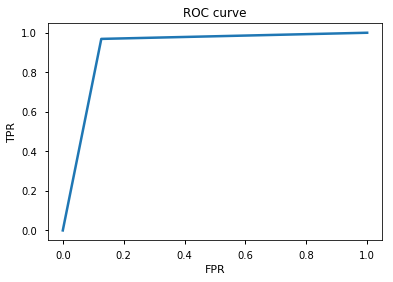

In [287]:
grid_search_random_forrest_best(X, y)

# Grid Search for Logistic Regression

In [288]:
def grid_search_log_reg(X, y):
    smote = SMOTE(kind='regular')
    X_sm, y_sm =  smote.fit_sample(X, y.ravel())
    X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42)
    log_reg = LogisticRegression()
    
    param_grid = { 
        'C' : np.logspace(-5, 8, 15)
    }
    grid_search = GridSearchCV(log_reg, param_grid=param_grid)
    
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    print(auc(false_positive_rate, true_positive_rate))
    print(roc_auc_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    plt.clf()
    plt.plot(false_positive_rate, true_positive_rate)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()

/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/infinityvoyager/anaconda3/lib/p

/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

0.8561121771319617
0.8561121771319617
              precision    recall  f1-score   support

           0       0.89      0.81      0.85     11005
           1       0.83      0.90      0.86     10924

   micro avg       0.86      0.86      0.86     21929
   macro avg       0.86      0.86      0.86     21929
weighted avg       0.86      0.86      0.86     21929



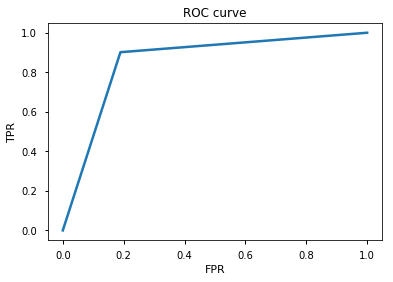

In [289]:
grid_search_log_reg(X, y)

In [290]:
def svc_grid_search(X, y):
    
    smote = SMOTE(kind='regular')
    X_sm, y_sm =  smote.fit_sample(X, y.ravel())
    
    X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42)
    
    svc = SVC()
    
    param_grid = {
        'C' : [1, 10, 100, 1000],
        'gamma' : [1, 0.1, 0.001, 0.0001],
        'kernel' : ['linear', 'rbf']
    }
    
    grid= GridSearchCV(svc, param_grid=param_grid)
    
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    print(auc(false_positive_rate, true_positive_rate))
    print(roc_auc_score(y_test, y_pred))
    
    print(classification_report(y_test, y_pred))
    

In [291]:
#svc_grid_search(X, y)

In [292]:
def gnb(X,y):
    
    smote = SMOTE(kind='regular')
    X_sm, y_sm =  smote.fit_sample(X, y.ravel())
    
    X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42)
    
    nb = GaussianNB()
    nb.fit(X_train,y_train)
    y_pred = nb.predict(X_test)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    print(auc(false_positive_rate, true_positive_rate))
    print(roc_auc_score(y_test, y_pred))
    
    print(classification_report(y_test, y_pred))
    plt.clf()
    plt.plot(false_positive_rate, true_positive_rate)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()

0.7408935862015384
0.7408935862015384
              precision    recall  f1-score   support

           0       0.74      0.74      0.74     11005
           1       0.74      0.74      0.74     10924

   micro avg       0.74      0.74      0.74     21929
   macro avg       0.74      0.74      0.74     21929
weighted avg       0.74      0.74      0.74     21929



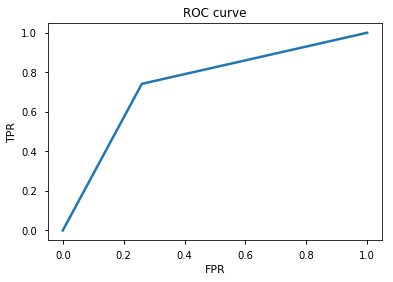

In [293]:
gnb(X,y)

In [294]:
X.columns

Index(['emp.var.rate', 'age', 'poutcome', 'nr.employed', 'duration',
       'euribor3m', 'education', 'day_of_week', 'campaign'],
      dtype='object')

In [295]:
X1=X.copy()

In [296]:
X1 = X1.drop('duration',axis=1)

0.8246700261573456
0.8246700261573456
              precision    recall  f1-score   support

           0       0.79      0.90      0.84     11005
           1       0.88      0.75      0.81     10924

   micro avg       0.82      0.82      0.82     21929
   macro avg       0.83      0.82      0.82     21929
weighted avg       0.83      0.82      0.82     21929



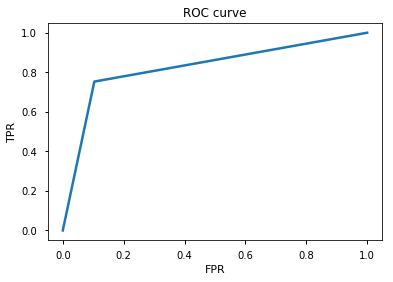

In [297]:
grid_search_random_forrest_best(X1, y)

In [298]:
X1 = X1.drop('euribor3m',axis=1)

0.799707952894485
0.799707952894485
              precision    recall  f1-score   support

           0       0.77      0.85      0.81     11005
           1       0.83      0.75      0.79     10924

   micro avg       0.80      0.80      0.80     21929
   macro avg       0.80      0.80      0.80     21929
weighted avg       0.80      0.80      0.80     21929



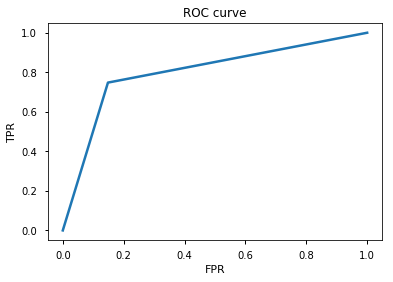

In [299]:
grid_search_random_forrest_best(X1, y)

In [300]:
# X1 = X1.drop('nr.employed',axis=1)
# grid_search_random_forrest_best(X1, y)

In [301]:
#predictions = tree.predict_proba(X_test)

# print(roc_auc_score(y_test, ))

# fpr, tpr, _ = roc_curve(y_test, predictions[:,1])

# plt.clf()
# plot.plot(fpr, tpr)
# plt.xlabel('FPR')
# plt.ylabel('TPR')
# plt.title('ROC curve')
# plt.show()

In [302]:
def knn(X,y):
    
    smote = SMOTE(kind='regular')
    X_sm, y_sm =  smote.fit_sample(X, y.ravel())
    
    X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42)
    
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    print(auc(false_positive_rate, true_positive_rate))
    print(roc_auc_score(y_test, y_pred))
    
    print(classification_report(y_test, y_pred))
    plt.clf()
    plt.plot(false_positive_rate, true_positive_rate)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()

0.9050942316589561
0.9050942316589561
              precision    recall  f1-score   support

           0       0.97      0.83      0.90     11005
           1       0.85      0.98      0.91     10924

   micro avg       0.90      0.90      0.90     21929
   macro avg       0.91      0.91      0.90     21929
weighted avg       0.91      0.90      0.90     21929



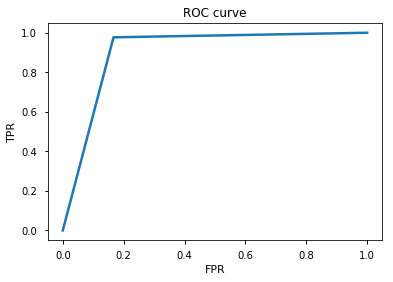

In [303]:
knn(X,y)

In [314]:
def ensemble_func(X,y):
    smote = SMOTE(kind='regular')
    X_sm, y_sm =  smote.fit_sample(X, y.ravel())
    
    X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42)

    model1 = RandomForestClassifier()
    model2 = KNeighborsClassifier()
    
    model = VotingClassifier(estimators=[('rf', model1), ('kn', model2)], voting='hard')
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    m_score = model.score(X_test,y_test)
    print('m_score ',m_score)
        
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    print(auc(false_positive_rate, true_positive_rate))
    print(roc_auc_score(y_test, y_pred))
    
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    
    plt.clf()
    plt.plot(false_positive_rate, true_positive_rate)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()
    

/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


m_score  0.9398969401249487
0.9398489560103086
0.9398489560103086
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     11005
           1       0.95      0.93      0.94     10924

   micro avg       0.94      0.94      0.94     21929
   macro avg       0.94      0.94      0.94     21929
weighted avg       0.94      0.94      0.94     21929

[[10486   519]
 [  799 10125]]


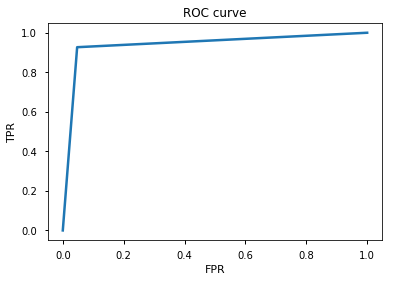

In [315]:
ensemble_func(X,y)

In [306]:
def ensemble_func2(X,y):
    smote = SMOTE(kind='regular')
    X_sm, y_sm =  smote.fit_sample(X, y.ravel())
    
    X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42)

    model1 = RandomForestClassifier()
    #model2 = KNeighborsClassifier()
    model3 = LogisticRegression()
    
    model = VotingClassifier(estimators=[('rf', model1), ('lr', model3)], voting='hard')
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    model.score(X_test,y_test)

        
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    print(auc(false_positive_rate, true_positive_rate))
    print(roc_auc_score(y_test, y_pred))
    
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    
    plt.clf()
    plt.plot(false_positive_rate, true_positive_rate)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()

/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/infinityvoyager/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9052963966813128
0.9052963966813128
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     11005
           1       0.95      0.86      0.90     10924

   micro avg       0.91      0.91      0.91     21929
   macro avg       0.91      0.91      0.91     21929
weighted avg       0.91      0.91      0.91     21929

[[10473   532]
 [ 1541  9383]]


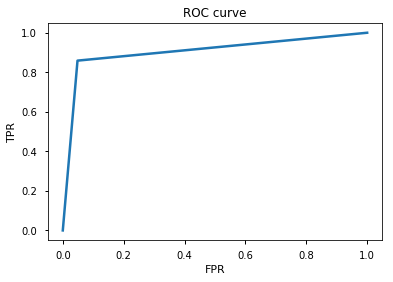

In [307]:
ensemble_func2(X,y)

In [312]:
def xgboost(X, y):
    smote = SMOTE(kind='regular')
    X_sm, y_sm =  smote.fit_sample(X, y.ravel())
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    model = XGBClassifier(n_estimators=50, max_depth=4)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(model.score(X_test, y_test))
    print(classification_report(y_test, y_pred))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    print(auc(false_positive_rate, true_positive_rate))
    print(roc_auc_score(y_test, y_pred))
    
    plt.clf()
    plt.plot(false_positive_rate, true_positive_rate)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()
    return rfc

0.9128429230395727
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     10965
           1       0.72      0.37      0.49      1392

   micro avg       0.91      0.91      0.91     12357
   macro avg       0.82      0.68      0.72     12357
weighted avg       0.90      0.91      0.90     12357

0.6761793009104202
0.6761793009104202


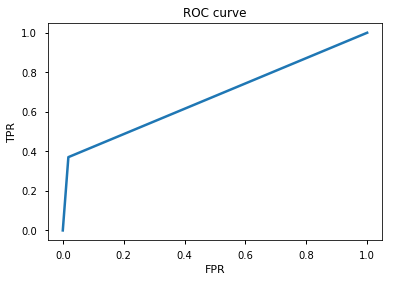

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [313]:
xgboost(X, y)